# Configurations

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def euclideanDistance(coord1,coord2):
    return np.sqrt((coord1[0]-coord2[0])**2+(coord1[1]-coord2[1])**2)

def getLinecut(image,X,Y,pt1,pt2):
    row_col_1, row_col_2 = getRowCol(pt1,X,Y), getRowCol(pt2,X,Y)
    row1,col1 = np.asarray(row_col_1).astype(float)
    row2,col2 = np.asarray(row_col_2).astype(float)
    dist = np.sqrt((pt1[0]-pt2[0])**2+(pt1[1]-pt2[1])**2)
    N = int(euclideanDistance(row_col_1,row_col_2))#int(np.sqrt((row1-row2)**2+(col1-col2)**2))
    rowList = [int(row1 + (row2-row1)/N*ind) for ind in range(N)]
    colList = [int(col1 + (col2-col1)/N*ind) for ind in range(N)]
    distList = [dist/N*ind for ind in range(N)]
    return distList,image[rowList,colList]#rowList,colList

def getRowCol(pt,X,Y):
    if X.min()<=pt[0]<=X.max() and Y.min()<=pt[1]<=Y.max():
        pass
    else:
        raise ValueError('The input center is not within the given scope.')
    center_coord_rowCol = (np.argmin(abs(Y-pt[1])),np.argmin(abs(X-pt[0])))
    return center_coord_rowCol

# Taking a linecut given two points (coordinates)

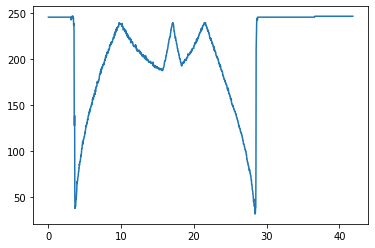

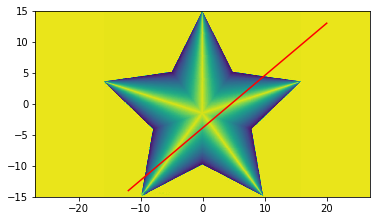

In [2]:
image = np.asarray(Image.open('./Picture1.png'))[:,:,1]#1087px-Five_Pointed_Star_Solid.svg.png #'./LabTools/qttest/img.jpg'#stsci-h-p2031b-m-2000x1778.png
image_copy = image.copy().astype(float)

X = np.linspace(-27,27,np.shape(image)[1])#[::-1]
Y = np.linspace(-15,15,np.shape(image)[0])[::-1]

pt1, pt2 = (-12,-14), (20,13)
distList, linecut = getLinecut(image_copy,X,Y,pt1,pt2)
plt.plot(distList, linecut)

plt.figure()
plt.pcolormesh(X,Y,image_copy)
plt.plot([pt1[0],pt2[0]],[pt1[1],pt2[1]],color='red')
plt.gca().set_aspect(1)

# Averaging linecuts across a given point with angle steps

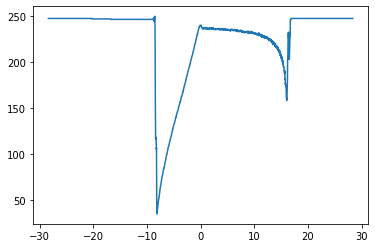

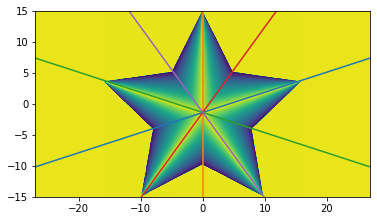

In [3]:
from scipy.interpolate import interp1d

def binarySearch(left,right,conditionFunction,threshold=1e-5):
    if euclideanDistance(left,right)/euclideanDistance(right,(0,0))<=threshold:#np.sqrt((left[0]-right[0])**2+(left[1]-right[1])**2)/np.sqrt((right[0])**2+(right[1])**2) <= 1e-5:
        return left
    middle = (left+right)/2
    if conditionFunction(middle) is False:
        result = binarySearch(middle,right,conditionFunction)
    else:
        result = binarySearch(left,middle,conditionFunction)
    return result

def exclusionCondition(pt,X,Y):
    if X.min()<=pt[0]<=X.max() and Y.min()<=pt[1]<=Y.max():
        return False
    else:
        return True

def getEdgePointsAcrossCenter(image,X,Y,center,angleDegree):
    unitVector = np.asarray([np.cos(angleDegree*np.pi/180),np.sin(angleDegree*np.pi/180)])
    unitVectorPos = unitVector
    unitVectorNeg = unitVector
    trialEdgePos = np.asarray(center).astype(float)
    trialEdgeNeg = np.asarray(center).astype(float)
    while not exclusionCondition(trialEdgeNeg,X,Y):
        trialEdgeNeg -= unitVectorNeg
        unitVectorNeg *= 2
    left = trialEdgeNeg + unitVectorNeg/2
    right = trialEdgeNeg
    edgeNeg = binarySearch(left,right,lambda middle: exclusionCondition(middle,X,Y))
    while not exclusionCondition(trialEdgePos,X,Y):
        trialEdgePos += unitVectorPos
        unitVectorPos *= 2
    left = trialEdgePos - unitVectorPos/2
    right = trialEdgePos
    edgePos = binarySearch(left,right,lambda middle: exclusionCondition(middle,X,Y))
    return edgeNeg,edgePos

def radialAverage(graph,center,X,Y,angleSteps,angleOffsetDegree = 0):
    if angleSteps%2 == 0:
        angleUnitDegree = 180/angleSteps # changed to 2*np.pi instead of np.pi for radialAverageByLinecuts. Different from radialAverageByLines with opposite lists sperately.
    else:
        angleUnitDegree = 360/angleSteps
    angleArrayDegree = np.array([angleOffsetDegree + angleUnitDegree*ind for ind in range(angleSteps)])

    interpDB = []
    div = np.inf
    minValue = np.inf
    maxValue = -np.inf
    edgePtsDB = []
    for angleDegree in angleArrayDegree:
        edgeNeg,edgePos = getEdgePointsAcrossCenter(graph,X,Y,center,angleDegree)
        edgePtsDB.append([edgeNeg,edgePos])
        distNeg = euclideanDistance(edgeNeg,center)
        distList, linecut = getLinecut(graph,X,Y,edgeNeg,edgePos)
        distArray = np.asarray(distList)-distNeg
        interp = interp1d(distArray,linecut,kind='nearest')
        interpDB.append(interp)
        currDiv = distArray[1]-distArray[0]
        if currDiv < div:
            div = currDiv
        if distArray[-1] > maxValue:
            maxValue = distArray[-1]
        if distArray[0] < minValue:
            minValue = distArray[0]
    combinedDistArray = np.linspace(minValue,maxValue,int((maxValue-minValue)/currDiv))
    combinedCountArray = np.zeros(combinedDistArray.shape)
    combinedLinecut = np.zeros(combinedDistArray.shape)
    for ind in range(len(interpDB)):
        interp = interpDB[ind]
        xmax = np.max(interp.x)
        xmin = np.min(interp.x)
        selectCondition = (combinedDistArray<=xmax) & (combinedDistArray>=xmin)
        rangedCombinedDistArray = np.clip(combinedDistArray,xmin,xmax)#combinedDistArray[selectCondition]
        countArray = np.zeros(combinedDistArray.shape)
        countArray[selectCondition] = 1
        combinedCountArray += countArray
        linecut = interp(rangedCombinedDistArray)
        linecut[np.invert(selectCondition)] = 0.
        combinedLinecut += linecut
    combinedLinecut /= combinedCountArray
    return combinedDistArray,combinedLinecut,edgePtsDB

center = (0,-1.4)
numLines = 5

combinedDistArray,combinedLinecut,edgePtsDB = radialAverage(image_copy,center,X,Y,numLines,
                                                            angleOffsetDegree=18)

plt.plot(combinedDistArray,combinedLinecut)
plt.figure()

plt.pcolormesh(X,Y,image_copy)
plt.gca().set_aspect(1)
for ind in range(len(edgePtsDB)):
    edgeNeg,edgePos = edgePtsDB[ind]
    plt.plot([edgeNeg[0],edgePos[0]],[edgeNeg[1],edgePos[1]])